## Survival Analysis

In [1]:
!pip install lifelines

     |████████████████████████████████| 409 kB 4.1 MB/s 
     |████████████████████████████████| 48 kB 4.0 MB/s 
     |████████████████████████████████| 82 kB 219 kB/s 
     |████████████████████████████████| 38.1 MB 48.5 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=df91f45aa6cef180267015228db8e141c1db8e22214cf49b59fe832683fee015
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.1
    Uninstalling typing-extensions-3.7.4.1:
      Successfully uninstalled typing-extensions-3.7.4.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.3
    Uninstalling autograd-1.3:
      

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introduction

### 1.1. What is Survival Analysis?



**Survival analysis** is a branch of statistics for analyzing the expected duration of time until one or more events happen, such as death in biological organisms and failure in mechanical systems. This topic is called reliability theory or reliability analysis in engineering, duration analysis or duration modelling in economics, and event history analysis in sociology. For the sake of consistency, this topic is covered within the medical context. Survival analysis attempts to answer certain questions, such as what is the proportion of a population which will survive past a certain time? Of those that survive, at what rate will they die or fail? Can multiple causes of death or failure be taken into account? How do particular circumstances or characteristics increase or decrease the probability of survival? More generally, survival analysis involves the modelling of time to event data.

### 1.2. Time to Event Data

Time to Event Data consist of a time period and event for every subject. Time is measured until the event occurs. This period could be the time from diagnosis or start of treatment to death of cancer patients, the time to metastasis or to local recurrence of a tumour. The event doesn't necessarily have to be a bad thing. It can be recovery or anything positive as well. Because of the examples of time to event data which were first studied, such data are often knows as survival or failure time data. The statistical techniques developed to deal with them are known as survival analysis.

In this notebook, [Breast Cancer (METABRIC)](https://www.kaggle.com/gunesevitan/breast-cancer-metabric) dataset is used for the analysis. It consists of clinical profiles of 2,509 breast cancer patients, time period between diagnosis and death, and time period between diagnosis and relapse.

In [3]:
df_metabric = pd.read_csv('../input/breast-cancer-metabric/Breast Cancer METABRIC.csv')

print(f'METABRIC Dataset Shape: {df_metabric.shape}')
print(f'METABRIC Dataset Memory Usage: {df_metabric.memory_usage().sum() / 1024 ** 2:.2f} MB')

METABRIC Dataset Shape: (2509, 34)
METABRIC Dataset Memory Usage: 0.65 MB


### 1.3. Breast Cancer (METABRIC) Dataset EDA

There are 2,509 unique breast cancer patients in METABRIC dataset as mentioned above. Those patients are diagnosed at ages between 21.9-96.3 and their mean diagnosis age is 60.4. Patients had underwent to two different surgeries; Mastectomy (removal of all breast tissue from a breast) or Breast-conserving surgery (removal of a part of the breast that has cancer). There are 2,506 breast cancer and 3 breast sarcoma patients in the dataset since breast sarcomas are a very rare form of breast cancer, that cover fewer than 1% of all breast cancers. The most common histological subtype of the breast cancer is invasive ductal carcinoma (IDC) with 1865 occurences. IDC is the most common form of breast cancer, representing 80% of all breast cancer diagnoses. Those indicators show that this dataset reflects real world scenarios very accurately.

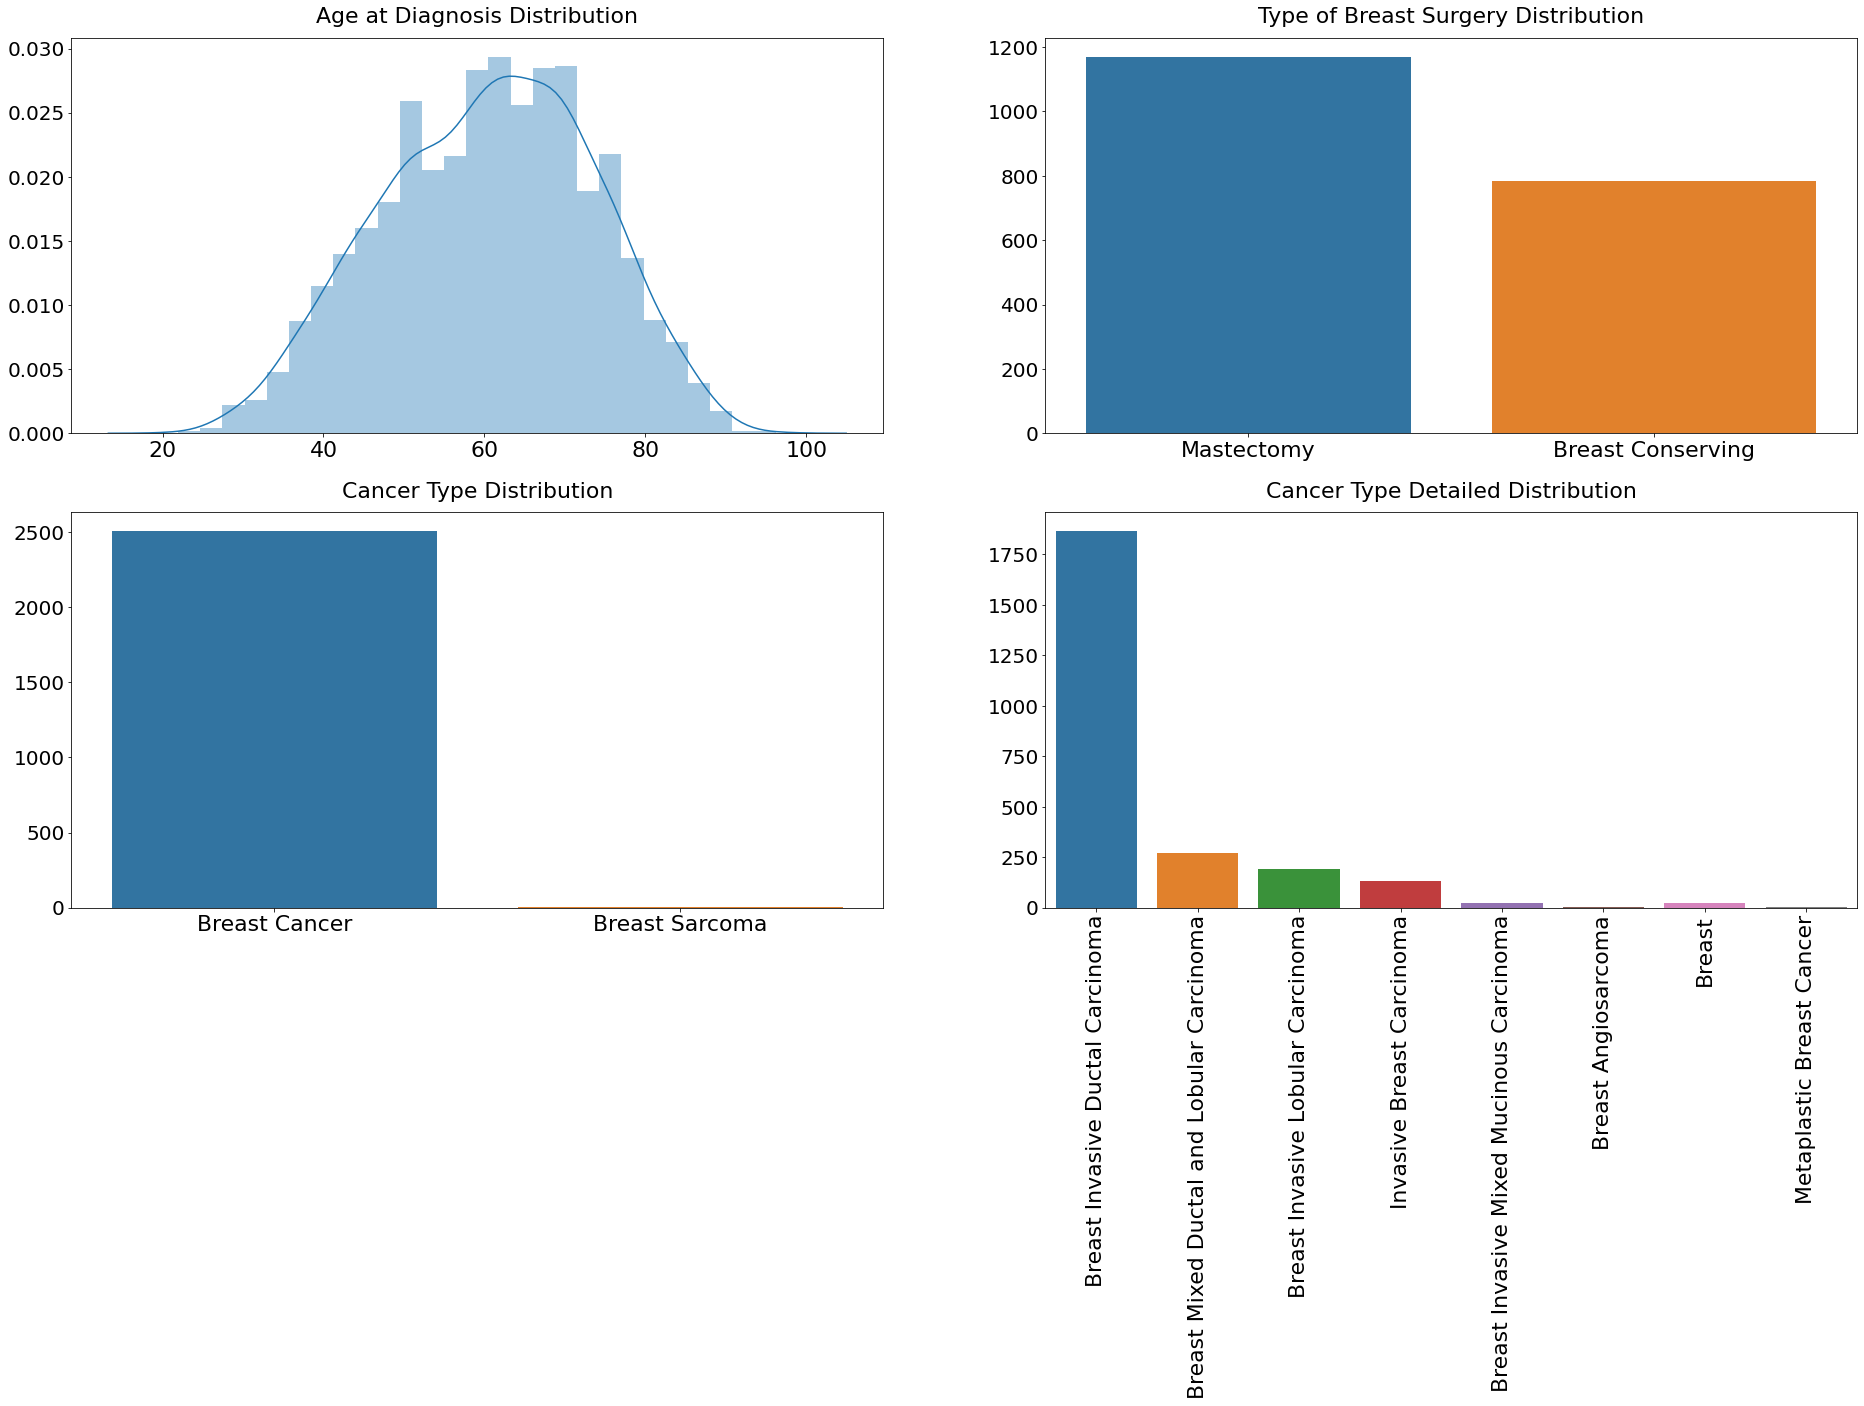

In [4]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(df_metabric['Age at Diagnosis'], ax=axes[0][0])
sns.countplot(df_metabric['Type of Breast Surgery'], ax=axes[0][1])
sns.countplot(df_metabric['Cancer Type'], ax=axes[1][0])
sns.countplot(df_metabric['Cancer Type Detailed'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22, rotation=90)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=20)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Age at Diagnosis Distribution', size=22, pad=15)
axes[0][1].set_title('Type of Breast Surgery Distribution', size=22, pad=15)
axes[1][0].set_title('Cancer Type Distribution', size=22, pad=15)
axes[1][1].set_title('Cancer Type Detailed Distribution', size=22, pad=15)

plt.show()

There are two events listed in the dataset. Those events are survival (`Overall Survival Status`) and relapse (`Relapse Free Status`). There are also two durations associated with those events which are `Overall Survival (Months)` and `Relapse Free Status (Months)`. Survival analysis is based on those two events and their durations. Both of the durations follow very similar distributions, but distribution of events are slightly different. For survival event, "Deceased" label is more common that corresponds to event happened, but in relapse event "Not Recurred" label is more common and that corresponds to event didn't happen.

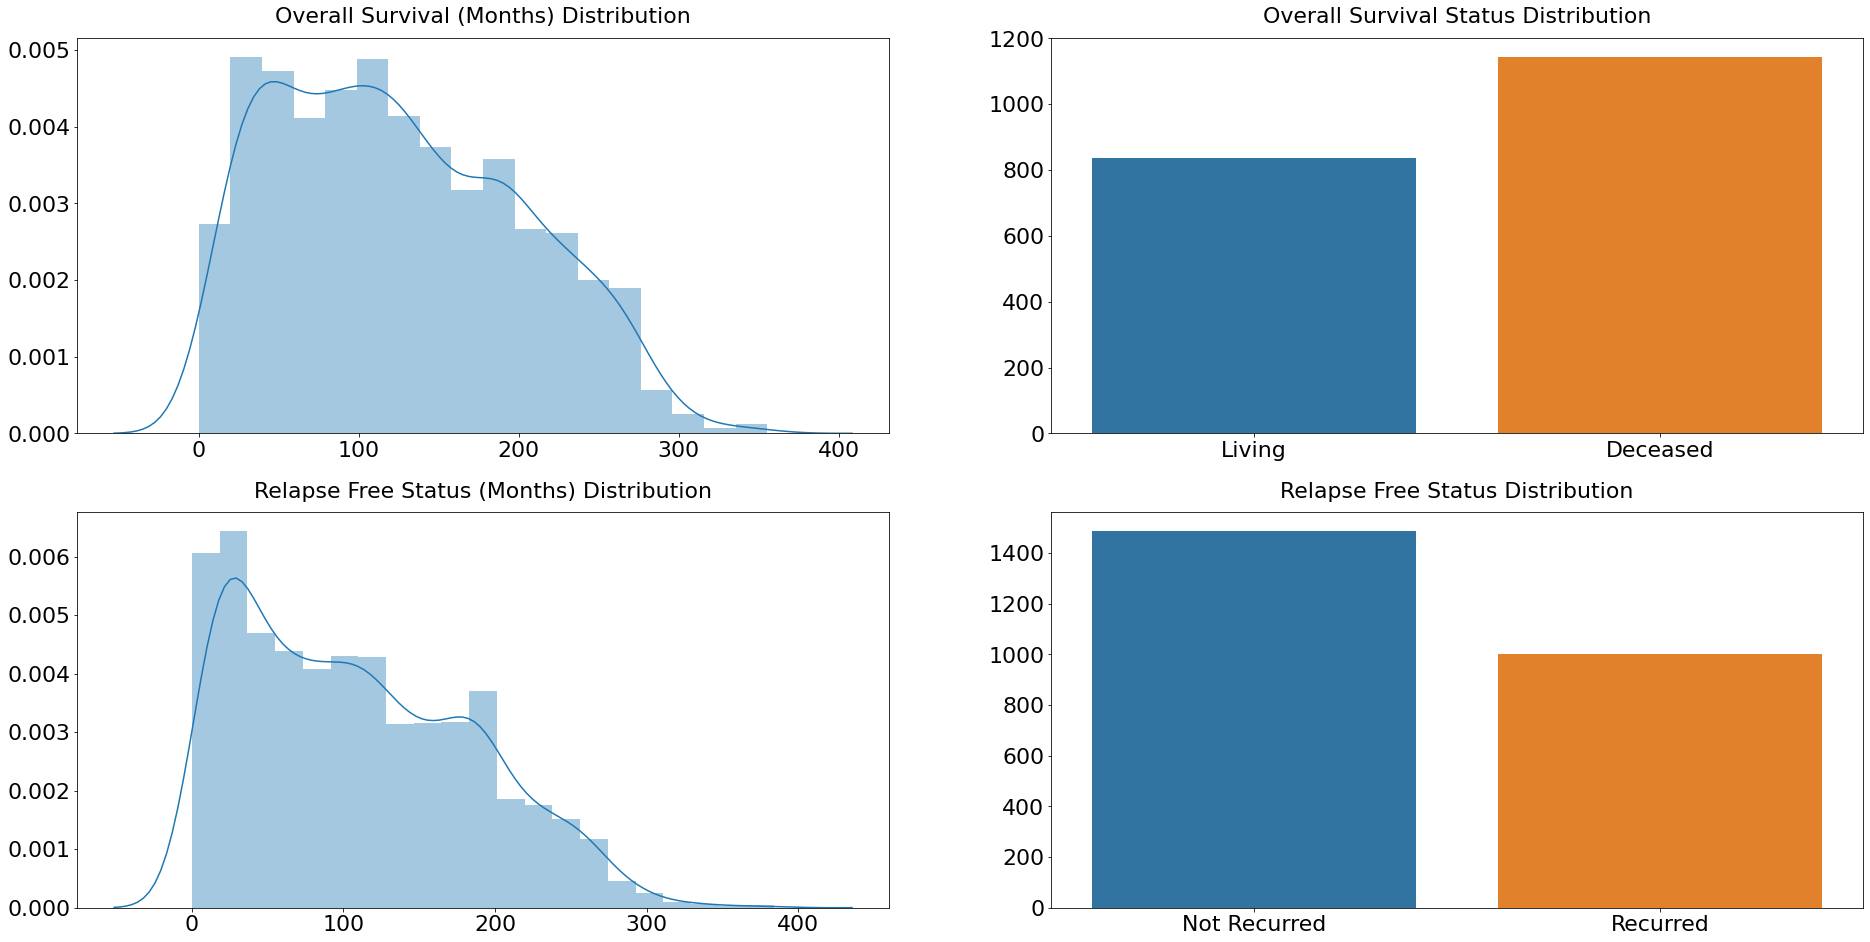

In [5]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(df_metabric['Overall Survival (Months)'], ax=axes[0][0])
sns.countplot(df_metabric['Overall Survival Status'], ax=axes[0][1])
sns.distplot(df_metabric['Relapse Free Status (Months)'], ax=axes[1][0])
sns.countplot(df_metabric['Relapse Free Status'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=22)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Overall Survival (Months) Distribution', size=22, pad=15)
axes[0][1].set_title('Overall Survival Status Distribution', size=22, pad=15)
axes[1][0].set_title('Relapse Free Status (Months) Distribution', size=22, pad=15)
axes[1][1].set_title('Relapse Free Status Distribution', size=22, pad=15)

plt.show()

Other features in the dataset are clinical profiles of the patients. Those features consist of tumor cellularity, whether the patient had taken chemotherapy, hormone therapy, radio therapy or not, ER, PR, HER2 status, tumor histologic subtype, size, stage and etc. Those features can be used as covariates in survival analysis models, but they require extra preprocessing and cleaning.

In [6]:
df_metabric.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Ductal/NST,Yes,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Mixed,Yes,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,Positive,3.0,Neutral,Negative,Mixed,Yes,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


### 1.4. Preprocessing and Cleaning

There are 29 columns with missing values and only 5 columns don't have missing values in them. Those columns are Sex, Cancer Type Detailed, Cancer Type, Oncotree Code, and Patient ID. Cancer Type and Cancer Type Detailed can be very useful for imputation, but others don't yield any information.                          

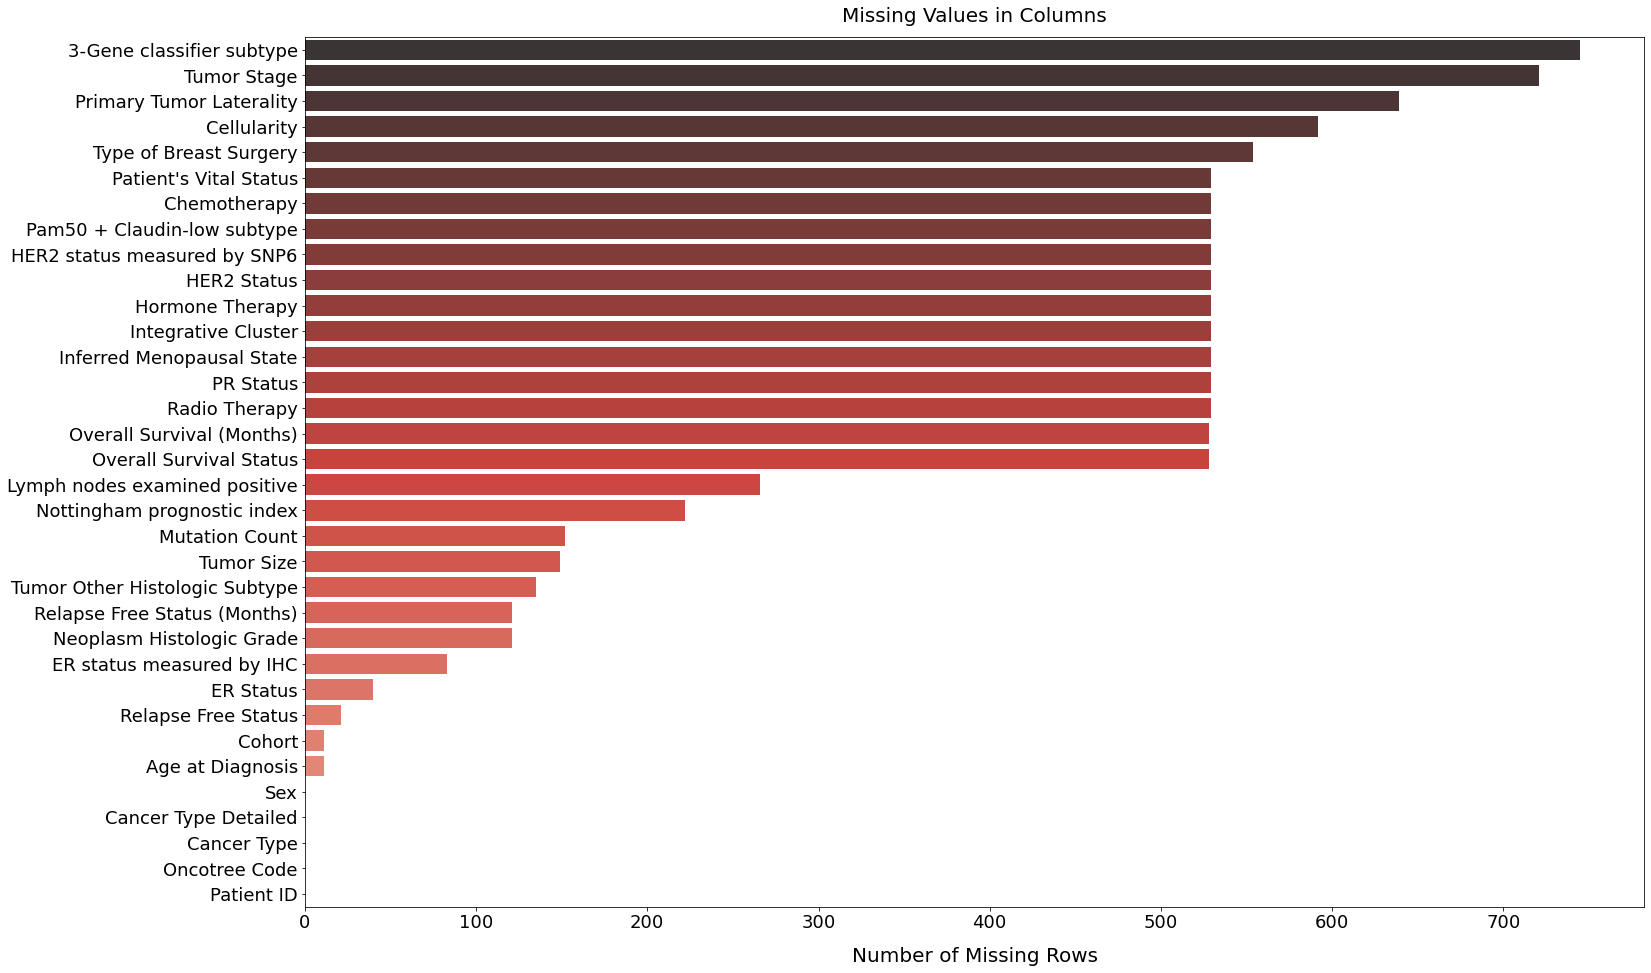

In [7]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=df_metabric.isnull().sum().sort_values(ascending=False).values,
            y=df_metabric.isnull().sum().sort_values(ascending=False).index,
            palette='Reds_d')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

Dependencies between different columns are exploited during the imputation stage. Missing values in event columns are filled with their most common value and missing values in duration columns are filled with most common values of Cancer Type Detailed, Event groups. Missing values in ER, PR and HER2 Status columns are filled with the most common values of their measurement technique columns (ER status measured by IHC and HER2 status measured by SNP6). Missing values in Chemotherapy, Hormone therapy, and Radio therapy are filled with the most common values in Cancer Type Detailed groups. Missing values in other columns are filled with modes or medians of different groups based on their dependencies. Some of the columns couldn't be filled with one operation so they are filled iteratively. Finally, Patient's Vital Status column is dropped because it doesn't yield any extra information for the analysis.

In [8]:
# Event and duration columns
df_metabric['Relapse Free Status'] = df_metabric.groupby(['Cancer Type Detailed'])['Relapse Free Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Relapse Free Status (Months)'] = df_metabric.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].apply(lambda x: x.fillna(x.mean()))
df_metabric['Overall Survival Status'] = df_metabric.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Overall Survival Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Overall Survival (Months)'] = df_metabric.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].apply(lambda x: x.fillna(x.mean()))

# ER, PR, HER2 status columns
df_metabric['ER status measured by IHC'] = df_metabric['ER status measured by IHC'].fillna(mode(df_metabric['ER status measured by IHC'])[0][0])
df_metabric['ER Status'] = df_metabric.groupby(['ER status measured by IHC'])['ER Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['HER2 status measured by SNP6'] = df_metabric['HER2 status measured by SNP6'].fillna(mode(df_metabric['HER2 status measured by SNP6'])[0][0])
df_metabric['HER2 Status'] = df_metabric.groupby(['HER2 status measured by SNP6'])['HER2 Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['PR Status'] = df_metabric.groupby(['Cancer Type Detailed'])['PR Status'].apply(lambda x: x.fillna(mode(x)[0][0]))

# Chemotherapy, Hormone Therapy, Radio Therapy columns
df_metabric['Chemotherapy'] = df_metabric.groupby(['Cancer Type Detailed'])['Chemotherapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Hormone Therapy'] = df_metabric.groupby(['Cancer Type Detailed'])['Hormone Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Radio Therapy'] = df_metabric.groupby(['Cancer Type Detailed'])['Radio Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))

# Other columns
df_metabric['Age at Diagnosis'] = df_metabric.groupby(['Cancer Type Detailed'])['Age at Diagnosis'].apply(lambda x: x.fillna(x.mean()))
df_metabric['Cohort'] = df_metabric.groupby(['Cancer Type Detailed'])['Cohort'].apply(lambda x: x.fillna(x.median()))
df_metabric['Cellularity'] = df_metabric.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Tumor Stage'] = df_metabric.groupby(['Cancer Type Detailed', 'Cellularity'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Stage'] = df_metabric.groupby(['Cancer Type Detailed'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Size'] = df_metabric.groupby(['Cancer Type Detailed', 'Tumor Stage'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Size'] = df_metabric.groupby(['Cancer Type Detailed'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Size'] = df_metabric['Tumor Size'].fillna(mode(df_metabric['Tumor Size'])[0][0])
df_metabric['Neoplasm Histologic Grade'] = df_metabric.groupby(['Cancer Type Detailed'])['Neoplasm Histologic Grade'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Neoplasm Histologic Grade'] = df_metabric['Neoplasm Histologic Grade'].fillna(mode(df_metabric['Neoplasm Histologic Grade'])[0][0])
df_metabric['Primary Tumor Laterality'] = df_metabric.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Tumor Other Histologic Subtype'] = df_metabric.groupby(['Cancer Type Detailed'])['Tumor Other Histologic Subtype'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Tumor Other Histologic Subtype'] = df_metabric['Tumor Other Histologic Subtype'].fillna('Ductal/NST')
df_metabric['Mutation Count'] = df_metabric.groupby(['Cancer Type Detailed'])['Mutation Count'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Mutation Count'] = df_metabric['Mutation Count'].fillna(mode(df_metabric['Mutation Count'])[0][0])
df_metabric['Nottingham prognostic index'] = df_metabric.groupby(['Tumor Size'])['Nottingham prognostic index'].apply(lambda x: x.fillna(x.median()))
df_metabric['Nottingham prognostic index'] = df_metabric['Nottingham prognostic index'].fillna(df_metabric['Nottingham prognostic index'].median())
df_metabric['Lymph nodes examined positive'] = df_metabric.groupby(['Cancer Type Detailed'])['Lymph nodes examined positive'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Lymph nodes examined positive'] = df_metabric['Lymph nodes examined positive'].fillna(mode(df_metabric['Lymph nodes examined positive'])[0][0])
df_metabric['Inferred Menopausal State'] = df_metabric['Inferred Menopausal State'].fillna(mode(df_metabric['Inferred Menopausal State'])[0][0])
df_metabric['Pam50 + Claudin-low subtype'] = df_metabric.groupby(['Cancer Type Detailed'])['Pam50 + Claudin-low subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Integrative Cluster'] = df_metabric.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Type of Breast Surgery'] = df_metabric.groupby(['Cancer Type Detailed'])['Type of Breast Surgery'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Primary Tumor Laterality'] = df_metabric.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['3-Gene classifier subtype'] = df_metabric.groupby(['Cancer Type Detailed'])['3-Gene classifier subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))

df_metabric.drop(columns=["Patient's Vital Status"], inplace=True)

At the final preprocessing stage, object type columns are label encoded and casted to uint8 for less memory consumption. Two event columns; Overall Survival Status and Relapse Free Status are manually encoded because `LabelEncoder` can label "event happened" as 0. This concludes the introduction part of this notebook, and makes the data prepared for the models.

In [9]:
object_cols = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity',
               'Chemotherapy', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC',
               'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
               'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality',
               'Oncotree Code', 'PR Status', 'Radio Therapy', 'Sex', '3-Gene classifier subtype']

for col in object_cols:
    df_metabric[col] = np.uint8(LabelEncoder().fit_transform(df_metabric[col]))
    
df_metabric['Overall Survival Status'] = np.uint8(df_metabric['Overall Survival Status'].map({'Living': 0, 'Deceased': 1}))
df_metabric['Relapse Free Status'] = np.uint8(df_metabric['Relapse Free Status'].map({'Not Recurred': 0, 'Recurred': 1}))

Since every column is numerical now, their correlations can be calculated. There are some strong relationships above 0.6 and below -0.6 which makes sense because lots of features are dependent to each other. There is also one perfect positive correlation between Cellularity and Integrative Cluster, so one of them should be dropped. One important thing to consider is, there is a strong correlation between two events, Overall Survival Status is dependent Relapse Free Status. Those features shouldn't be used as covariates because of this reason. Finally, there is an empty row and column which corresponds to Sex column. They are empty because all of the patients are female, so Sex column has 0 variance and no correlations.

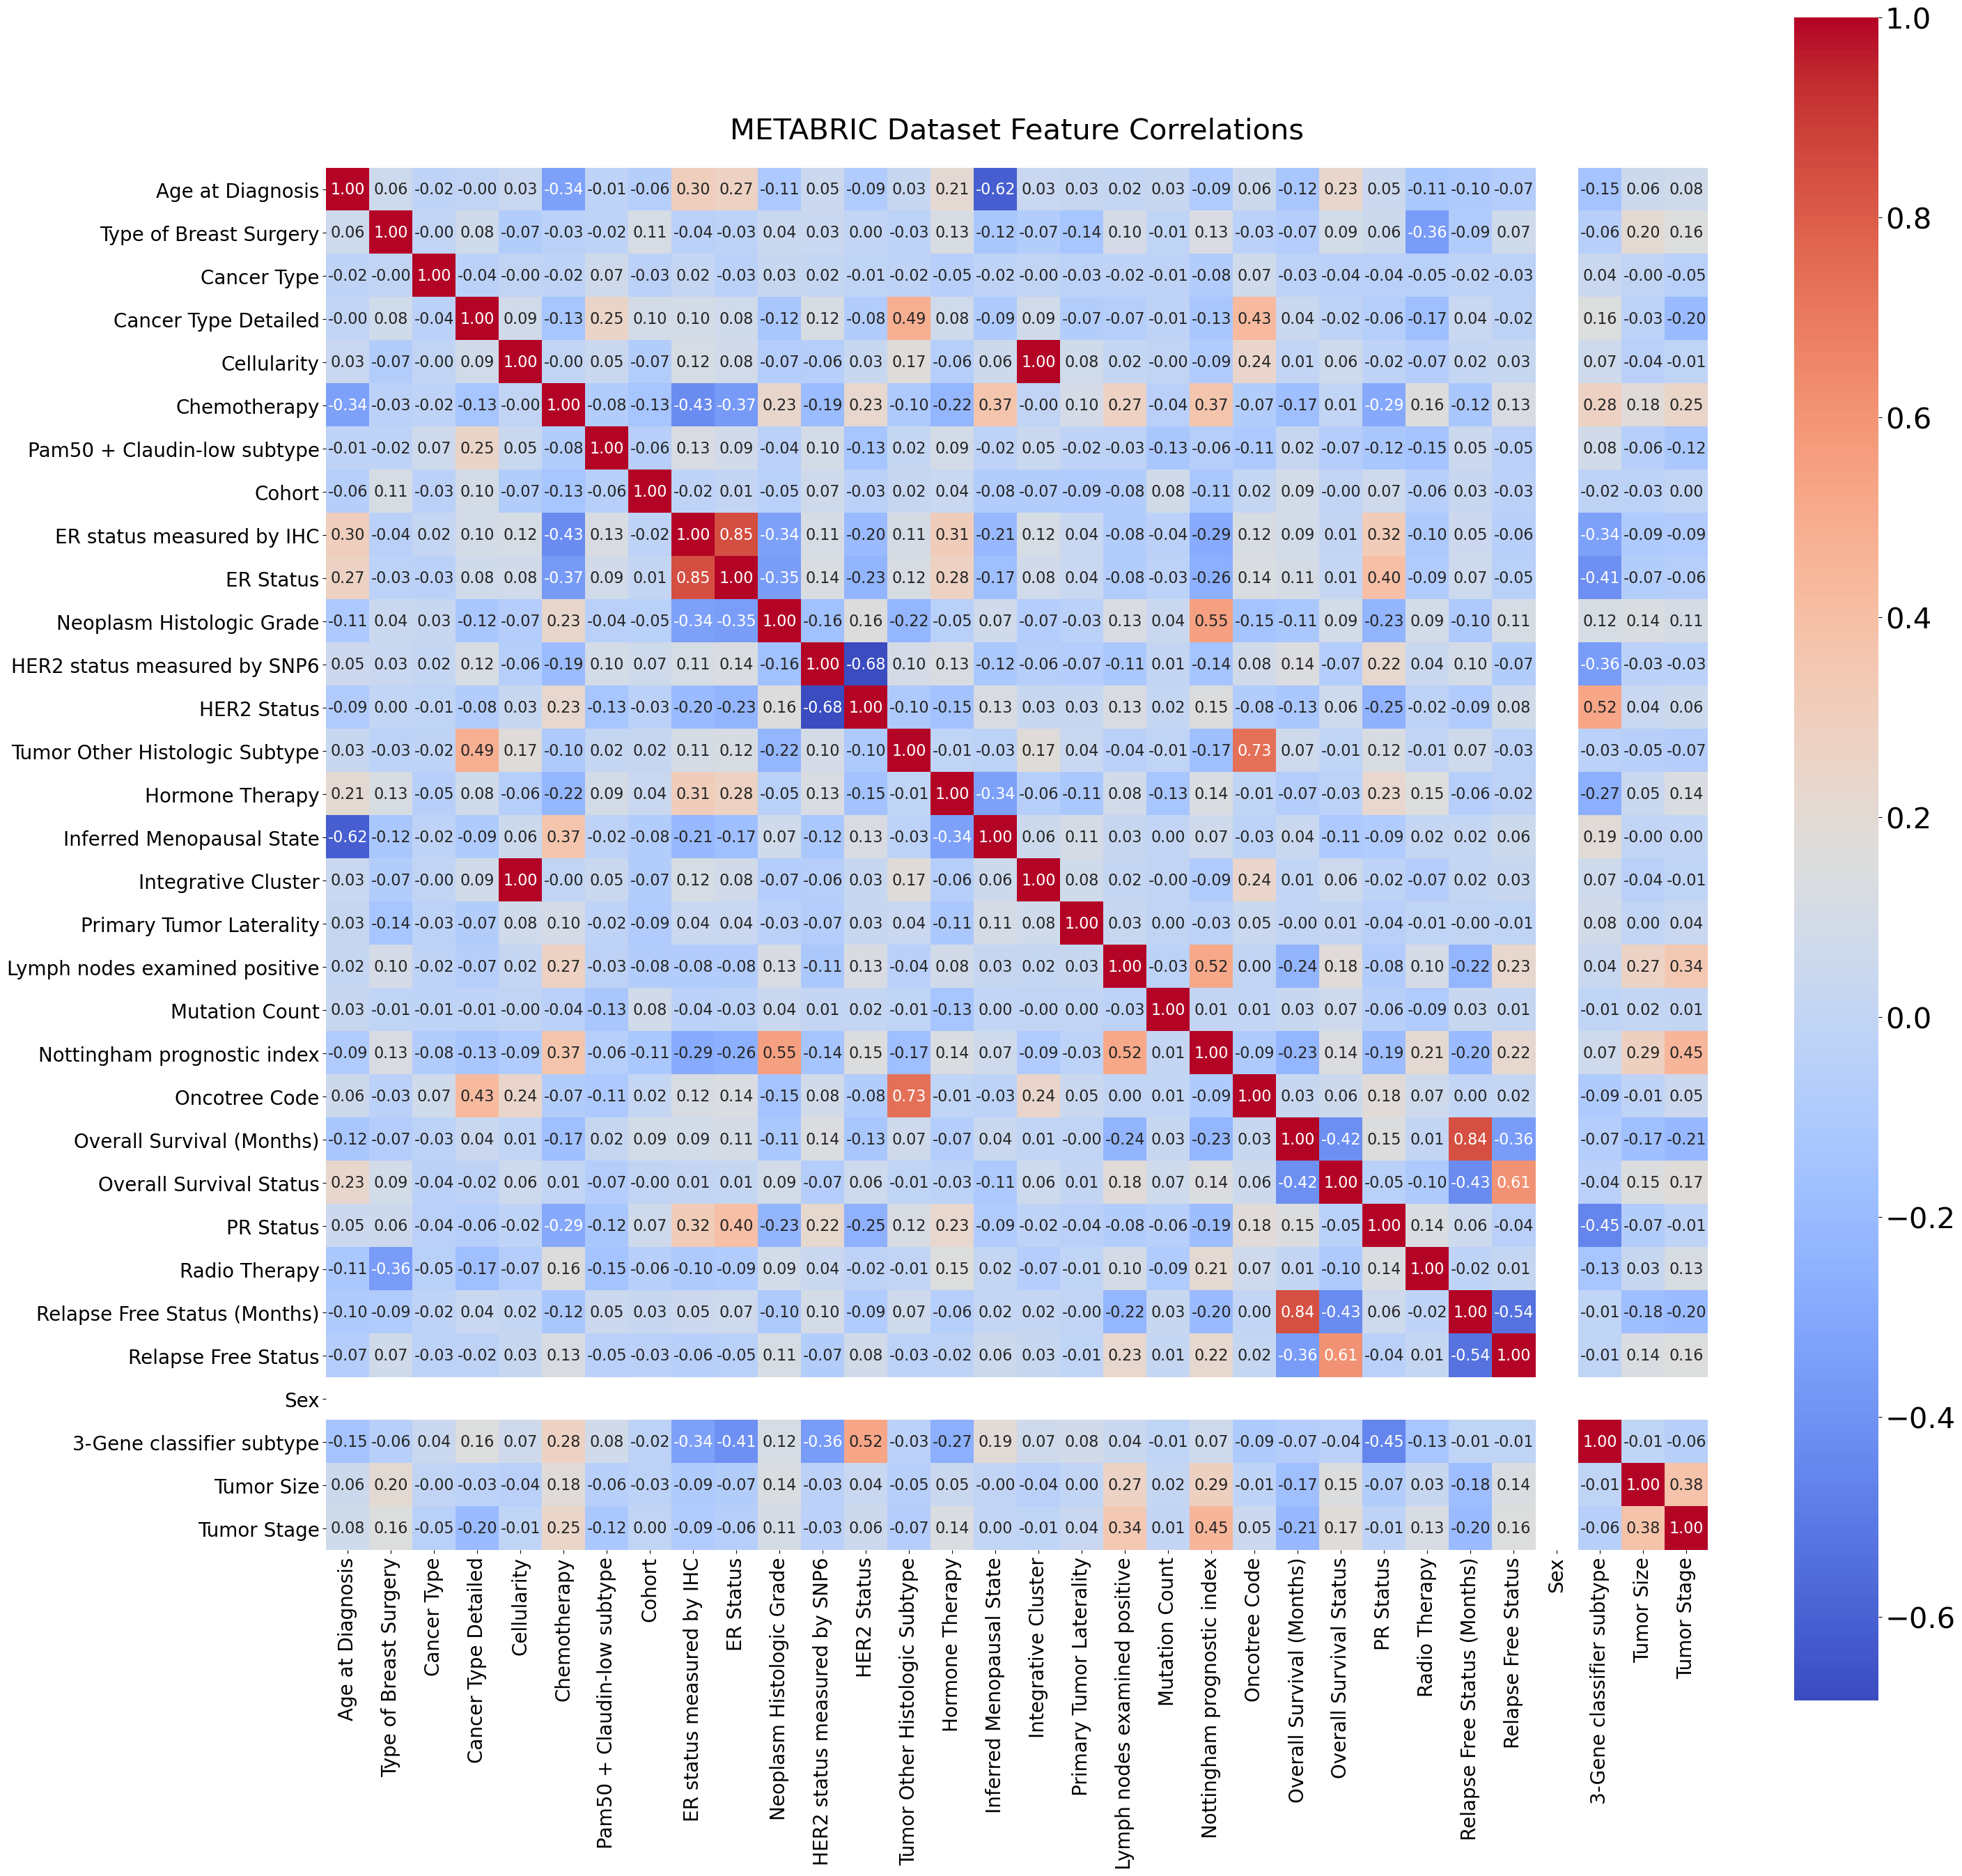

In [10]:
fig = plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(df_metabric.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 16},  fmt='.2f')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)
plt.title('METABRIC Dataset Feature Correlations', size=30, pad=30)

plt.show()

In [11]:
df_metabric.drop(columns=['Integrative Cluster'], inplace=True)

## 2. Theory

### 2.1. Survival Function

The set of methods related to survival analysis has the goal to estimate the survival function from survival data. Let $T$ be a (possibly infinite, but always non-negative) random duration taken from the dataset under study. The survival function - $S(t)$ - of a population is defined as $S(t) = Pr(T > t)$. Simply, the survival function defines the probability of the event has not occurred yet at time $t$, or equivalently, the probability of surviving past time $t$. [2]

$T$ is the random lifetime taken from the dataset under study and cannot be negative. The survival function $S(t)$ outputs values between 0 and 1 and is a non-increasing function of $t$.At the start of the time ($t=0$), no subject has experienced the event yet. Therefore the probability $S(0)$ of surviving beyond time zero is 1. $S(∞)=0$ since if the study period were limitless, presumably everyone eventually would experience the event of interest and the probability of surviving would ultimately fall to 0. In theory the survival function is smooth, in practice the events are observed on a concrete time scale, e.g. days, weeks, months, etc., such that the graph of the survival function is like a step function. [3]

![img](https://i.ibb.co/SXJVyDG/surv.jpg)[4]

### 2.2. Hazard Function

The hazard function $h(t)$ gives the probability of the event occurring at time $t$, given that the event has not occurred yet. It describes the instantaneous potential per unit time for the event to occur. It is formulated as: 

$\Large\lim_{\delta t \rightarrow 0 } \; Pr( t \le T \le t + \delta t | T > t)$

This quantity goes to $0$ as $δt$ shrinks, so it is divided by the interval $δt$. This defines the hazard function at time $t$, $h(t)$:

$\Large h(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le T \le t + \delta t | T > t)}{\delta t}$

Therefore, hazard function models which periods have the highest or lowest chances of an event. In contrast to the survival function, the hazard function does not have to start at 1 and go down to 0. The hazard rate usually changes over time. It can start anywhere and go up and down over time.

![hazard](https://i.ibb.co/C0bFCfr/hazard.png)

## 3. Censoring

One basic concept needed to understand survival analysis is censoring. In survival analysis, there are two types of observations:

* Event occurred and it was able to get measured when it occurred
* The event didn't occur during the observed time, and only total number of days in which it didn’t occur is known (censored)

Those are the two groups, one where the time to event is known exactly and one where it is not. The second group is only known to have a certain amount of time where the event of interest did not occur. This group is the censored subjects. A common mistake is choosing to ignore the censored group. We don’t know event would have occurred if we observed the individual longer, but knowing that it didn’t occur for so long tells something about the risk of the event for that person.

One cause of censoring is merely that we can’t follow people forever.  At some point the study has to end, and not all people will have experienced the event. Another common cause is that people are lost to follow-up during the study. This is called random censoring. It occurs when follow-up ends for reasons that are not under control of the investigator.

In survival analysis, censored observations contribute to the total number at risk up to the time that they ceased to be followed.  One advantage here is that the length of time that an individual is followed does not have to be equal for everyone. All observations could have different amounts of follow-up time, and the analysis can take that into account. [5]

There are 3 types of censoring: **right**, **left** and **interval** censoring. Those types of censoring are explained below.

### 3.1. Right Censoring

Right-censoring is the most common type of censoring. It occurs when the survival time is incomplete at the right side of the follow-up period. Consider the example where we have 3 patients (A, B, C) enrolled onto a clinical study that runs for some period of time (study end - study start). There are 3 patients with different trajectories plotted below.

* **Patient A**: Experiences event before the study ends
* **Patient B**: Survives passed the end of the study
* **Patient C**: Withdraws from the study.

Patient A requires no censoring since we know their exact survival time which is the time until death. Patient B however needs to be censored since we don’t know the exact survival time of the patient. We only know that they survived during the study. Patient C also needs to be censored since they withdrew before the study ended. So we only know that they survived up to the time they withdrew, but again we don’t know the exact survival time of this patient. In right censoring, the true survival times will always be equal to or greater than the observed survival time. [6]

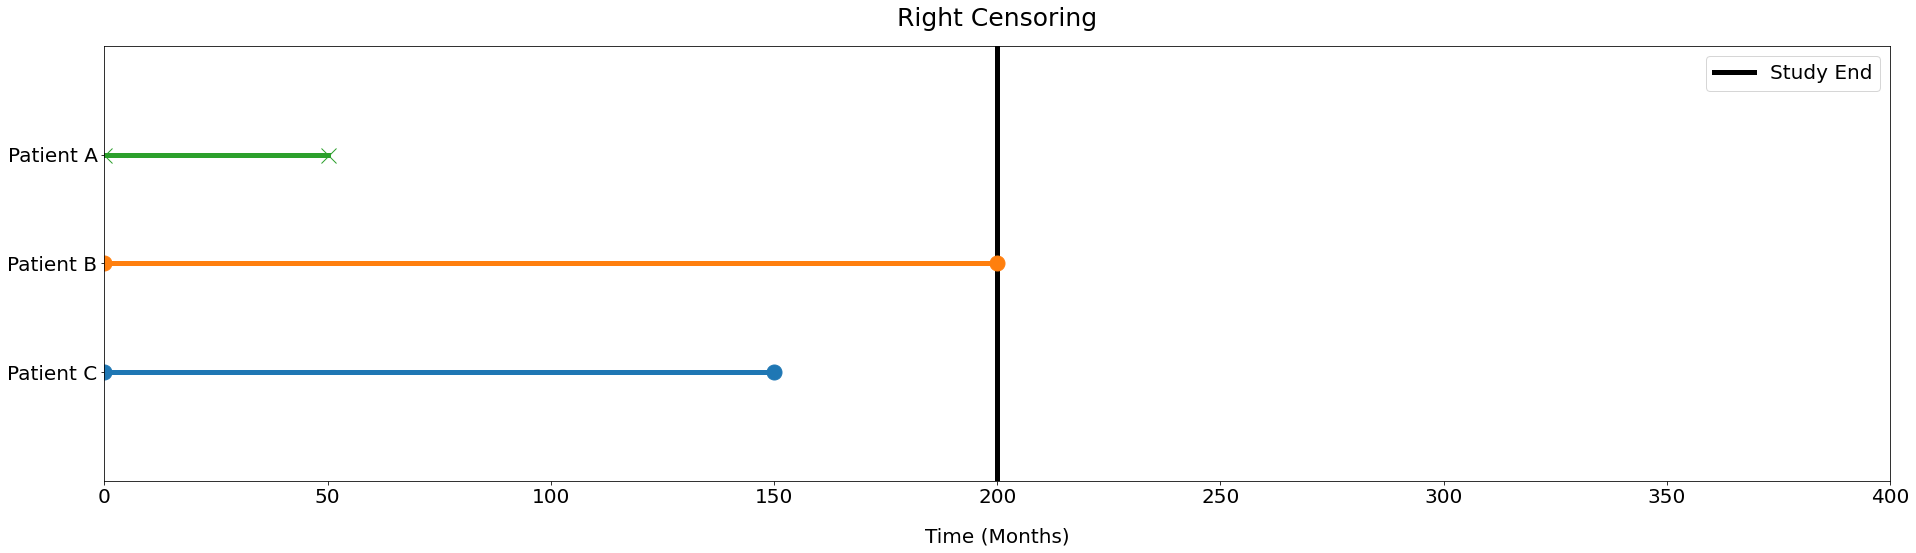

In [12]:
fig = plt.figure(figsize=(32, 8))

plt.xlim(0, 400), plt.ylim(0, 4)
plt.axvline(200, color='black', label='Study End', linewidth=5)
plt.plot([0, 150], [1, 1], marker='o', markersize=15, linewidth=5)
plt.plot([0, 200], [2, 2], marker='o', markersize=15, linewidth=5)
plt.plot([0, 50], [3, 3], marker='x', markersize=15, linewidth=5)

plt.xlabel('Time (Months)', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.yticks([1, 2, 3], ['Patient C', 'Patient B', 'Patient A'])
plt.legend(prop={'size': 20})
plt.title('Right Censoring', size=25, pad=20)

plt.show()

### 3.2. Left Censoring

Left-censoring occurs when we cannot observe the time when the event occurred. For obvious reasons if the event is death, the data can’t be left-censored. A good example is virus testing. For instance, if we’ve been following an individual and recorded an event when the individual tests positive for a virus, but we don’t know the exact time of when the individual was exposed to the disease. We only know that there was some exposure between 0 and the time they were tested. [6]

### 3.3. Interval Censoring

Using the virus testing example, if we have the situation whether we’ve performed testing on the indvidual at some timepoint (t1) and the individual was negative. But then at a timepoint further on (t2), the individual tested positive. In this case, we know the individual was exposed to the virus sometime between t1 and t2, but we do not know the exact timing of the exposure. This can be given as an example interval censoring. [6]

## 4. Evaluation

Formulating survival analysis as ranking problem is an elegant way of dealing not only with the typically skewed distributions of survival times, but also with the censoring of the data. Two subjects’ survival times can be ordered not only if both of them are uncensored but also if the uncensored time of one is smaller than the censored survival time of the other.

For the reasons mentioned above, the **concordance index (CI)** or **c-index** is one of the most commonly used performance measures of survival models. It can be interpreted as the fraction of all pairs of subjects whose predicted survival times are correctly ordered among all subjects. In other words, it is the probability of concordance between the predicted and the observed survival. It can be written as

![c-index](https://i.ibb.co/dPqVG2m/c.jpg)

with the indicator function $1a<b = 1$ if $a < b$, and $0$ otherwise. $f(x_i)$ is the predicted survival time for subject $i$ by the model $f$. This index is a generalization of the Wilcoxon-Mann-Whitney statistics and thus of the area under the ROC curve (AUC) to regression problems in that it can be applied to continuous output variables and account for censoring of the data. Like for the AUC, c = 1 indicates perfect prediction accuracy and c = 0.5 is as good as a random predictor. [7]

lifelines package has an implementation of concordance index. It takes 3 parameters; event times (array-like object with durations), predicted scores (array-like partial hard rates or survival times), and event observed (array-like binary event data). Scoring function can be called with the following signature `lifelines.utils.concordance_index(event_times, predicted_scores, event_observed)`. Return value is the average of how often a model says X is greater than Y when, in the observed data, X is indeed greater than Y. This function also handles the censored values.

Another way to evaluate a survival model is ranking event probabilities at certain times. This method can be done with `time_dependent_roc_auc_score` function defined below. It initially converts (n_samples, 1) shaped ground truth labels to (n_samples, n_evaluation_times) shaped matrix. After that, `sklearn.metrics.roc_auc_score` is calculated for every time (column).

In [13]:
def time_dependent_roc_auc_score(y_true, y_pred, survival_times):

    """
    Calculate roc auc score at given times

    Parameters
    ----------
    y_true: array-like of shape (n_samples)
    Binary event vector
    y_pred: array-like of shape (n_samples, n_evaluation_times)
    Predicted event probabilities at given times
    survival_times: array-like of shape (n_samples)
    Continuous time vector

    Returns
    -------
    scores: dict (time: score)
    A dictionary of times and scores
    """

    time_dependent_y_true = pd.DataFrame(data=np.zeros((y_pred.shape[0], y_pred.shape[1])),
                                         index=y_true.index,
                                         columns=y_pred.columns,
                                         dtype=np.uint8)

    for i, time in enumerate(y_pred.columns):
        time_dependent_y_true.iloc[:, i] = ((y_true == 1) & (time >= survival_times)).astype(np.uint8)

    scores = {}
    for time in y_pred.columns:
        score = np.round(roc_auc_score(time_dependent_y_true[time], y_pred[time]), 6)
        scores[int(time)] = score

    return scores


## 5. Survival Models

Survival analysis models requires a specific dataset format:

* $E$ is the event indicator such that $E_i=1$, if an event happens, and $E_i=0$ in case of censoring
* $T$ is the observed duration
* $X$ is a n−dimensional feature vector (covariates)

The standard ways for survival estimation can be classified into the three main groups: **non-parametric**, **semi-parametric**, and **parametric** approaches.
Parametric methods rely on the assumptions that the distribution of the survival times corresponds to specific probability distributions. This group consists of methods such as exponential, Weibull and lognormal distributions. Parameters inside these models are usually estimated using certain maximum likelihood estimations.In the non-parametric methods there are no dependencies on the form of parameters in underlying distributions. Mostly, the non-parametric approach is used to describe survival probabilities as function of time and to give an average view of individual’s population. The most popular univariate method is the Kaplan-Meier estimator.To the semi-parametric methods corresponds the Cox regression model which is based both on parametric and non-parametric components. [3]

StratifiedKFold with 5 splits is used for cross-validation. Cancer Type Detailed is stratified, but some of the values are not perfectly stratified because they are very rare. For final evaluation, a holdout test set with same split technique is used.

In [14]:
df_train, df_test = train_test_split(df_metabric,
                                     test_size=0.2,
                                     stratify=df_metabric['Cancer Type Detailed'],
                                     shuffle=True,
                                     random_state=0)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
for fold, (_, val_idx) in enumerate(skf.split(df_train, df_train['Cancer Type Detailed']), 1):
    df_train.loc[val_idx, 'fold'] = fold

df_train['fold'] = df_train['fold'].astype(np.uint8)

## 6. Kaplan-Meier Estimate (Non-parametric Model)

The most common non-parametric technique for modeling the survival function is Kaplan-Meier estimate. Another way to think about survival analysis is non-negative regression and density estimation for a single random variable (first event time) in the presence of censoring. Kaplan-Meier is a non-parametric density estimate (empirical survival function) in the presence of censoring. The advantage of this model is that it’s very flexible, and model complexity grows with the number of observations. However, there are two disadvantages:

1. It isn’t easy to incorporate covariates, meaning that it’s difficult to describe how individuals differ in their survival functions based on the profiles. The main way to do it is to fit a different model on different subpopulations and compare them. However, as the number of characteristics and values of those characteristics grows, this is hard to scale.
2. The survival functions aren’t smooth.  In particular they are piecewise constant.  They approach a smooth estimator as the sample size grows, but for small samples they are far from smooth. It’s not clear that it’s realistic that the death probability ‘jumps’ in a small interval.  Furthermore, if you don’t have any death observations in the interval [0,t), then it will assign survival probability 1 to that period, which may not be desirable.  There are ways to smooth the survival function (kernel smoothing), but the interpretation of the smoothing can be a bit tricky.


The key idea of the Kaplan-Meier estimator is to break the estimation of the survival function $S(t)$ into smaller steps depending on the observed event times. For each interval the probability of surviving until the end of this interval is calculated, given the following formula:

$\Huge\hat{S(t)} = \prod_{i: t_i <= t}{\frac{n_i - d_i}{n_i}}$

where $n_i$ is a number of individuals who are at risk at time point $t_i$ and $d_i$ is a number of subjects that experienced the event at time $t_i$. [8]

Even though data is split into train, validation and test sets, `KaplanMeierFitter` is initially fit to entire dataset. Kaplan-Meier estimate can be used like this to get a general idea over the population. The estimated $S(t)$ is plotted as a stepwise function of overall population of individuals for both Overall Survival Status and Relapse Free Status events.

The y-axis represents the probability a patient is still alive or not relapsed after $t$ months, where $t$ months is on the x-axis. Confidence intervals are needed to report how uncertain we are about these point estimates which is the filled area around the lines. Wider confidence intervals mean the estimates are more uncertain, and vice versa. Confidence intervals are computed in the call to `fit()`, and located under the `confidence_interval_` property. The method uses exponential Greenwood confidence interval. Finally, dots are the right censored patients because their event time wasn't known at time $t$.

It can be seen that probability of event not happening is close to 1 at the start of the study and decreases to 0 over time. Estimates closer to start of the study are more confident while estimates closer to end of the study are less confident since it is harder to forecast future.

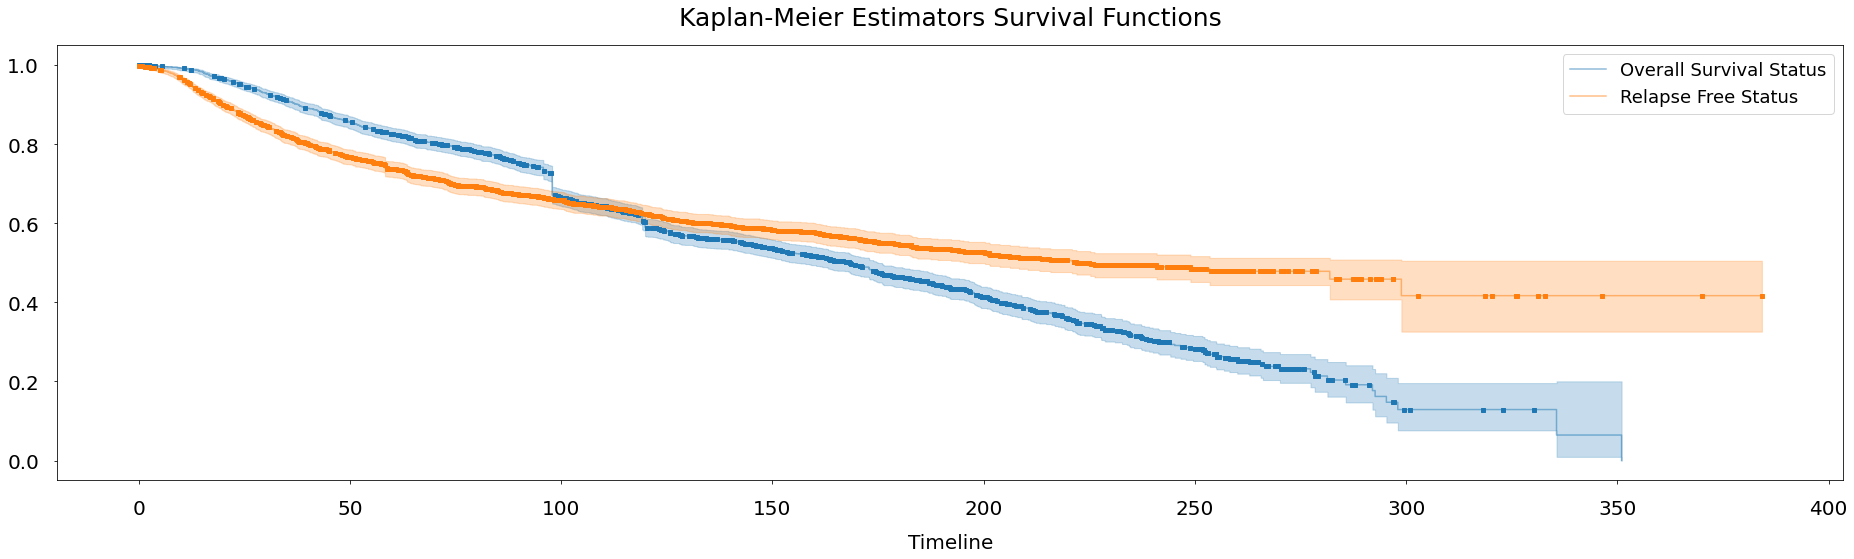

In [15]:
fig = plt.figure(figsize=(32, 8))

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
       
    T, E = df_train[time], df_train[event]
    kmf = KaplanMeierFitter()
    kmf.fit(T, E)
    kmf.plot(label=event, alpha=0.5, show_censors=True, censor_styles={'ms': 4, 'marker': 's'})
    
plt.xlabel('Timeline', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=20, pad=15)
plt.tick_params(axis='y', labelsize=20, pad=15)
plt.legend(prop={'size': 18})
plt.title('Kaplan-Meier Estimators Survival Functions', size=25, pad=20)

plt.show()

Kaplan-meier estimate can also be used for predicting survival probabilities of unseen data at given times. `lifelines.KaplanMeierFitter.predict` function takes `times` parameter which is a list of timesteps to predict probabilities at. For example, the model below tries to predict both events happening (separately) at 12, 24, and 36 months. Model is evaluated on 5 split cross-validation and unseen test set. 

0.5 Test ROC AUC scores suggest that Kaplan-Meier estimate fails to generalize on an unseen test set. That was expected because this model doesn't use patient covariates and it outputs same probabilities for every patient in the population. Besides low scores, Kaplan-Meier estimate doesn't output hazard rates, so it can't be evaluated with concordance index. That's why Kaplan-Meier estimate shouldn't be used for predictions, but it is very useful for exploratory data analysis.

In [16]:
evaluation_times = [12, 24, 36]

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
    
    df_oof_survival_function = pd.DataFrame(data=np.zeros((df_train.shape[0], len(evaluation_times))),
                                                index=df_train.index,
                                                columns=evaluation_times)
    df_test_survival_function = pd.DataFrame(data=np.zeros((df_test.shape[0], len(evaluation_times))),
                                             index=df_test.index,
                                             columns=evaluation_times)
    
    for fold in sorted(df_train['fold'].unique()):
                    
        trn_idx, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index       
        T_trn, E_trn = df_train.loc[trn_idx, time], df_train.loc[trn_idx, event]
        T_val, E_val = df_train.loc[val_idx, time], df_train.loc[val_idx, event]
        kmf = KaplanMeierFitter()
        kmf.fit(T_trn, E_trn)
        
        survival_function = kmf.predict(times=evaluation_times)        
        val_survival_function = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), T_val.shape[0])),
                                             index=val_idx,
                                             columns=evaluation_times)        
        df_oof_survival_function.loc[val_idx, :] = val_survival_function.values        
        test_survival_function = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), df_test.shape[0])),
                                              index=df_test.index,
                                              columns=evaluation_times)
        df_test_survival_function += (test_survival_function.values / n_splits)

        val_auc = time_dependent_roc_auc_score(df_train.loc[val_idx, event], val_survival_function, df_train.loc[val_idx, time])
        print(f'Fold {fold} ({time}) - ROC AUC Scores {val_auc}')
        
    oof_auc = time_dependent_roc_auc_score(df_train[event], df_oof_survival_function, df_train[time])
    test_auc = time_dependent_roc_auc_score(df_test[event], df_test_survival_function, df_test[time])
    print(f'{"-" * 30}\nKaplan Meier Estimate {time} OOF AUC: {oof_auc}')
    print(f'Kaplan-Meier Estimate {time} Test AUC: {test_auc}\n{"-" * 30}\n')


Fold 1 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------
Kaplan Meier Estimate Overall Survival (Months) OOF AUC: {12: 0.649796, 24: 0.524038, 36: 0.518953}
Kaplan-Meier Estimate Overall Survival (Months) Test AUC: {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------

Fold 1 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Relapse Fre

## 7. Cox Proportional Hazards Model (Semi-parametric Model)

Cox proportional hazards model is essentially a regression model commonly used in medical research for investigating the association between the survival time of patients and one or more covariates. The method mentioned above, Kaplan-Meier estimate is an example of univariate analysis. It describes the survival according to one factor under investigation, but ignore the impact of any others (patient covariates). Univariate analysis methods are only useful when the covariates are categorical (e.g.: males vs females). They don’t work easily for continuous covariates such as "age at diagnosis".

An alternative method to Kaplan-Meier estimate is the Cox proportional hazards model. It works for both continuous and categorical variables. Furthermore, the Cox proportional hazards model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time.

In [17]:
evaluation_times = [12, 24, 36]
os_covariates = ['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type',
                 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
                 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
                 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6',
                 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy',
                 'Inferred Menopausal State', 'Primary Tumor Laterality', 'Lymph nodes examined positive',
                 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'PR Status',
                 '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage']
rfs_covariates = ['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type',
                 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
                 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
                 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6',
                 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy',
                 'Inferred Menopausal State', 'Primary Tumor Laterality', 'Lymph nodes examined positive',
                 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'PR Status',
                 '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage']

for time, event, covariates in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'],
                                   ['Overall Survival Status', 'Relapse Free Status'],
                                   [os_covariates, rfs_covariates]):
    
    df_oof_survival_function = pd.DataFrame(data=np.zeros((df_train.shape[0], len(evaluation_times))), index=df_train.index, columns=evaluation_times)
    df_oof_hazard_rates = pd.DataFrame(data=np.zeros(df_train.shape[0]), index=df_train.index, columns=['Partial Hazard Rates'])
    df_test_survival_function = pd.DataFrame(data=np.zeros((df_test.shape[0], len(evaluation_times))), index=df_test.index, columns=evaluation_times)
    df_test_hazard_rates = pd.DataFrame(data=np.zeros(df_test.shape[0]), index=df_test.index, columns=['Partial Hazard Rates'])
    
    for fold in sorted(df_train['fold'].unique()):
                    
        trn_idx, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index       
        trn = df_train.loc[trn_idx, covariates + [time, event]]
        val = df_train.loc[val_idx, covariates + [time, event]]
        
        cph = CoxPHFitter(baseline_estimation_method='breslow',
                          n_baseline_knots=4,
                          penalizer=1e-2)
        cph.fit(trn, duration_col=time, event_col=event)
        
        val_survival_function = cph.predict_survival_function(val, times=evaluation_times).T
        test_survival_function = cph.predict_survival_function(df_test[covariates + [time, event]], times=evaluation_times).T
        df_oof_survival_function.loc[val_idx, :] = val_survival_function.values
        df_test_survival_function += (test_survival_function.values / n_splits)
        
        df_oof_hazard_rates.loc[val_idx, 'Partial Hazard Rates'] = -cph.predict_partial_hazard(val[covariates + [time, event]])
        df_test_hazard_rates[f'Partial Hazard Rates'] += -cph.predict_partial_hazard(df_test[covariates + [time, event]])

        val_auc = time_dependent_roc_auc_score(df_train.loc[val_idx, event], val_survival_function, df_train.loc[val_idx, time])
        val_ci = concordance_index(df_train.loc[val_idx, time], df_oof_hazard_rates.loc[val_idx, 'Partial Hazard Rates'], df_train.loc[val_idx, event])
        print(f'Fold {fold} ({time}) - ROC AUC Scores {val_auc} - Concordance Index: {val_ci:.6}')
        
    oof_auc = time_dependent_roc_auc_score(df_train[event], df_oof_survival_function, df_train[time])
    oof_ci = concordance_index(df_train[time], df_oof_hazard_rates['Partial Hazard Rates'], df_train[event])
    test_auc = time_dependent_roc_auc_score(df_test[event], df_test_survival_function, df_test[time])
    test_ci = concordance_index(df_test[time], df_test_hazard_rates['Partial Hazard Rates'], df_test[event])
    print(f'{"-" * 30}\nCox Proportional Hazards Model {time} - OOF ROC AUC Scores: {oof_auc} - Concordance Index: {oof_ci:.6}')
    print(f'Cox Proportional Hazards Model {time} - Test ROC AUC Scores: {test_auc} - Concordance Index: {test_ci:.6}\n{"-" * 30}\n')


Fold 1 (Overall Survival (Months)) - ROC AUC Scores {12: 0.405, 24: 0.215133, 36: 0.261681} - Concordance Index: 0.68849
Fold 2 (Overall Survival (Months)) - ROC AUC Scores {12: 0.302423, 24: 0.27154, 36: 0.271706} - Concordance Index: 0.668644
Fold 3 (Overall Survival (Months)) - ROC AUC Scores {12: 0.112228, 24: 0.318683, 36: 0.315144} - Concordance Index: 0.662762
Fold 4 (Overall Survival (Months)) - ROC AUC Scores {12: 0.144841, 24: 0.215091, 36: 0.23007} - Concordance Index: 0.668316
Fold 5 (Overall Survival (Months)) - ROC AUC Scores {12: 0.099578, 24: 0.246349, 36: 0.248634} - Concordance Index: 0.671966
------------------------------
Cox Proportional Hazards Model Overall Survival (Months) - OOF ROC AUC Scores: {12: 0.212921, 24: 0.254402, 36: 0.265274} - Concordance Index: 0.671959
Cox Proportional Hazards Model Overall Survival (Months) - Test ROC AUC Scores: {12: 0.29697, 24: 0.286557, 36: 0.236842} - Concordance Index: 0.65736
------------------------------

Fold 1 (Relapse

## References

* [[1] ("Survival Analysis", n.d.)](https://en.wikipedia.org/wiki/Survival_analysis)
* [[2] ("Introduction to survival analysis", n.d.)](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html)
* [[3] ("Deep Learning for Survival Analysis", 2020)](https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/#motivation)
* [[4] ("Kaplan meier survival curves and the log-rank test", 2013)](https://www.slideshare.net/zhe1/kaplan-meier-survival-curves-and-the-logrank-test)
* [[5] ("Applied Survival Analysis: Regression Modeling of Time-to-Event Data, 2nd Edition", 2011)](https://www.wiley.com/en-us/Applied+Survival+Analysis%3A+Regression+Modeling+of+Time+to+Event+Data%2C+2nd+Edition-p-9781118211588)
* [[6] ("The Basics of Survival Analysis", 2016)](https://tinyheero.github.io/2016/05/12/survival-analysis.html)
* [[7] ("On Ranking in Survival Analysis: Bounds on the Concordance Index", 2008)](https://www.slideshare.net/zhe1/kaplan-meier-survival-curves-and-the-logrank-test)
* [[8] ("When Should You Use Non-Parametric, Parametric, and Semi-Parametric Survival Analysis", 2018)](https://boostedml.com/2018/11/when-should-you-use-non-parametric-parametric-and-semi-parametric-survival-analysis.html#:~:text=The%20most%20common%20non%2Dparametric,in%20the%20presence%20of%20censoring.)